# Blight Fight Capstone Project

Jeison Cardoso - j@jsonzilla.com

## Introduction

The Blight Fight Capstone Project is a project that aims to develop a machine learning model to predict the relation between blight in buildings and crimes in Detroit. Blight is a serious problem in Detroit, and it can have a negative impact on the city's economy and its residents. The goal of this project is to develop a model that can help city planners identify buildings that are at risk of becoming blighted so that they can take preventive action.

## Data Analysis
The data that was used in this project was obtained from the City of Detroit's Open Data Portal. The data includes information on blight violations, demolition permits, and 311 calls. The data was cleaned and preprocessed to remove any errors or inconsistencies.

### Source Data
The original data can be found at the following links:
* [Blight Violations](https://d3c33hcgiwev3.cloudfront.net/_97bd1c1e5df9537bb13398c9898deed7_detroit-blight-violations.csv?Expires=1525305600&Signature=eFD51fReW6lMTqFcCeDbQ1kgqi8sYAwZP7vMgVhsOOlv2QDrs61mX1tIBwdaqjaCVezWE30qjVPBzimiEafX2itPJiEPovHCzlOWMvnPe8x5RIeS-SbU0yPbG6~AHF7Cb0XITaoKlVmnMIAtiLstPqOOYfdhjUILu5~1dRNu8SE_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A) - This data was obtained from the City of Detroit's Open Data Portal. It contains information on blight violations in the city of Detroit.
* [Demolition Permits](https://d3c33hcgiwev3.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-demolition-permits.tsv?Expires=1525305600&Signature=f1GJGdUQshH1-g6GhDS-yUETWwkRis45gX9L85AGoXEuDHSzEhfdXWdo~tEbD~XHSXeRMNrgogVy-EYmO8t~7nfTnYt96LAcNxe73BTgvGdBDO~LdvA222Z9zs0sRxZAifSPbXnsW9jbxlDaqdnZNvc~zOkWxCN9aYQ2sBFujYQ_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A) - This data was obtained from the City of Detroit's Open Data Portal. It contains information on demolition permits in the city of Detroit.
* [311 Calls](https://d3c33hcgiwev3.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-311.csv?Expires=1525305600&Signature=al11Hk1qn7CACblYpryhkWbcoHm6dXQkRw~Mu7y6ONBEDy0rdQIjLHvwN8IqOsV6OFNOudDrinXBEz-m5Q9A2GZrvR0~bbnuZbsFd7y7eQTv~o-NazxOfLPwRUwViGCxSxcQhwBTiV0VjySP4fgExZwFX2xVwQqInjrKQYHs8iM_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A) - This data was obtained from the City of Detroit's Open Data Portal. It contains information on 311 calls in the city of Detroit.
* [Crimes](https://d3c33hcgiwev3.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-crime.csv?Expires=1525305600&Signature=N0vg~4Jgqn6b-w-UEAQ3q0v3EbzgM9akDsHbn2o54WCdzh0Zzw~yJrcoBTHzkpBu0b3e4IiEFHUdKgVjryQRumLznIbaqEe146IC7FJqq8QqYWHVLcfquK9f3IXfCzoSNGeXGPWgT2l0BbzwAR6hxHeKxAxrXEajM7YWNwwIL7U_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A) - This data was obtained from the City of Detroit's Open Data Portal. It contains information on crimes in the city of Detroit.

## Cleaning the data

The first step is to clean the data. We will remove the columns that are not useful for our analysis and remove the rows that have missing values.

### Import the base libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

### Auxiliary functions
Function to filter and extract the data from the datasets.

#### Filter date limits
Filter the data from the datasets by the date limits.

In [29]:
def filter_date_limits(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter the dataframe to only include dates between 2013-01-01 and 2017-01-01
    """
    return df[(df["DATE"] <= datetime.datetime(2017,1,1)) & (df["DATE"] >= datetime.datetime(2013,1,1))]

#### Filter geographic limits
Filter by a pseudo-geographical bounding box, to get a better precision in the results.

In [30]:
def filter_geo_limits(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter the dataframe to only include locations within the Detroit city limits
    """
    df = df[(df['GEO_LAT'] > 42.25) & (df['GEO_LAT'] < 42.47)]
    df = df[(df['GEO_LON'] > -83.3) & (df['GEO_LON'] < -82.9)]
    df = df.dropna(subset=['GEO_LAT', 'GEO_LON'])
    return df

#### Extract geolocation
Extract the geolocation from the dataset. Some data has a format like ```SOMETHING (LAT, LON)```, so we need to extract the latitude and longitude from the string.

In [31]:
def extract_geo_location(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Extract the geo location from the given label and add it to the dataframe
    """
    df.dropna(subset=[label], inplace=True)
    df["GEO_LAT"] = df[label].str.extract(r"(\d+\.\d+),\s(-\d+\.\d+)", expand=True)[0].astype(float)
    df["GEO_LON"] = df[label].str.extract(r"(\d+\.\d+),\s(-\d+\.\d+)", expand=True)[1].astype(float)
    df.dropna(subset=['GEO_LAT', 'GEO_LON'], inplace=True)
    return df

#### Create a geolocation grid
Create a data structure to store the grid of geolocations. This grid is a pseudo grid, as it is not a regular grid. The grid is defined by the center of the grid, the number of rows and columns and the size of the grid. The size of the grid is the size of the grid in meters. The grid is a square grid. The grid is defined by a tile size in meters.

In [32]:
def create_geo_location_grid(tile_size: int):
    """
    Create a grid of the given tile size for the Detroit city limits
    """
    grid = {"lat":[42.25,42.47],"lon":[-83.3,-82.9],"x": 26300,"y": 26300}
    lat = (grid["lat"][1]-grid["lat"][0])*tile_size/grid["y"]
    lon = (grid["lon"][1]-grid["lon"][0])*tile_size/grid["x"]
    x = int(grid["x"]/tile_size) + 1
    y = int(grid["y"]/tile_size) + 1
    return {"lat":lat,"lon":lon,"x":x,"y":y,"factor":tile_size}

#### Convert geography coordinates to the pseudo grid coordinates
Convert the geographical coordinates to the pseudo grid coordinates. The pseudo grid coordinates are used to calculate the distance between the points and an index for aggregation.

In [33]:
def convert_geo_location_to_grid(df: pd.DataFrame, grid: dict) -> pd.DataFrame:
    """
    Convert the geo location to a grid location
    """
    x = ((df["GEO_LON"]-grid["lon"])/grid["lon"]).astype(int)
    y = ((df["GEO_LAT"]-grid["lat"])/grid["lat"]).astype(int)
    df.insert(0, "GEO_INDEX", x + y*grid["x"])
    return df

### Cleaning process
The first step is creating a pseudo grid, to create the grid object that is a common data for all processing. The grid object is a dictionary with the following keys:
* lat: latitude of the grid
* lon: longitude of the grid
* x: x coordinate of the grid
* y: y coordinate of the grid
* factor: the size of the grid

```python
{"lat":lat,"lon":lon,"x":x,"y":y,"factor":tile_size}
```

In [34]:
grid = create_geo_location_grid(tile_size=30)

#### Cleaning Permits Data
After read the data, we extract the column of date when the permit as applied, the size of the parcel and ground area. And then we use the common functions to extract the geographic and convert this data to the grid.

In [35]:
permits = pd.read_csv("./data/detroit-demolition-permits.tsv", sep="\t")
permits = permits[permits["PERMIT_APPLIED"].str.contains("^[0-9]{2}/[0-9]{2}/[0-9]{2}$")]
permits["DATE"] = pd.to_datetime(permits["PERMIT_APPLIED"], format="%m/%d/%y")
permits["PARCEL_SIZE"] = permits["PARCEL_SIZE"].astype(float).fillna(0)
permits["PARCEL_GROUND_AREA"] = permits["PARCEL_GROUND_AREA"].astype(float).fillna(0)
permits = extract_geo_location(permits, "site_location")
permits = filter_geo_limits(permits)
permits = filter_date_limits(permits)
permits = convert_geo_location_to_grid(permits, grid)
permits = permits[["GEO_INDEX", "GEO_LAT", "GEO_LON", "DATE", "PARCEL_SIZE", "PARCEL_GROUND_AREA"]]

permits.head()

,GEO_INDEX,GEO_LAT,GEO_LON,DATE,PARCEL_SIZE,PARCEL_GROUND_AREA
1517,148007437,42.404182,-82.988822,2014-12-19,6011.0,982.0
1518,147972940,42.394451,-83.123028,2014-12-19,3920.0,0.0
1519,148056587,42.418207,-82.971459,2014-12-19,3877.0,792.0
1520,148056587,42.418207,-82.971459,2014-12-19,3877.0,792.0
1521,147753854,42.331681,-83.047996,2014-12-19,3006.0,960.0


#### Cleaning Crimes Data
After read the data, we extract the column of date of the incident. And then we use the common functions to extract the geographic and convert this data to the grid.

In [36]:
crimes = pd.read_csv("./data/detroit-crime.csv", low_memory=False)
crimes['GEO_LON'] = crimes['LON'].astype(float)
crimes['GEO_LAT'] = crimes['LAT'].astype(float)
crimes['DATE'] = pd.to_datetime(crimes['INCIDENTDATE'], format='%m/%d/%Y %I:%M:%S %p')

crimes = filter_geo_limits(crimes)
crimes = filter_date_limits(crimes)
crimes = convert_geo_location_to_grid(crimes, grid)
crimes = crimes[['GEO_INDEX', 'GEO_LON', 'GEO_LAT', 'CATEGORY', 'DATE']]

crimes.head()

,GEO_INDEX,GEO_LON,GEO_LAT,CATEGORY,DATE
0,147879980,-83.1221,42.3678,ASSAULT,2015-06-03
1,147895587,-83.2035,42.3724,LARCENY,2015-03-01
2,148110845,-83.0241,42.4338,STOLEN VEHICLE,2015-02-08
3,147815923,-83.1381,42.3496,WEAPONS OFFENSES,2015-11-09
4,147810813,-83.0692,42.3481,LARCENY,2015-08-14


#### Clean Violations Data
After read the data, we extract the column of date when the ticket as created, then extract all the monetary information to find some correlation. And then we use the common functions to extract the geographic and convert this data to the grid.

In [37]:
violations = pd.read_csv('./data/detroit-blight-violations.csv', low_memory=False)
violations = violations[violations["TicketIssuedDT"].str.contains("^[0-9]{2}/[0-9]{2}/[0-9]{4} [0-9]{2}:[0-9]{2}:[0-9]{2}")]
violations["DATE"] = pd.to_datetime(violations["TicketIssuedDT"], format='%m/%d/%Y %I:%M:%S %p')
violations = extract_geo_location(violations, "ViolationAddress")
violations = filter_geo_limits(violations)
violations = filter_date_limits(violations)
violations['FineAmt'] = violations['FineAmt'].str.replace('$', '').astype(float).fillna(0)
violations['AdminFee'] = violations['AdminFee'].str.replace('$', '').astype(float).fillna(0)
violations['LateFee'] = violations['LateFee'].str.replace('$', '').astype(float).fillna(0)
violations['StateFee'] = violations['StateFee'].str.replace('$', '').astype(float).fillna(0)
violations['CleanUpCost'] = violations['CleanUpCost'].str.replace('$', '').astype(float).fillna(0)
violations['JudgmentAmt'] = violations['JudgmentAmt'].str.replace('$', '').astype(float).fillna(0)
violations = violations[['GEO_LAT', 'GEO_LON', 'DATE', 'FineAmt', 'AdminFee', 'LateFee', 'StateFee', 'CleanUpCost', 'JudgmentAmt']]
violations = violations.dropna()
violations = convert_geo_location_to_grid(violations, grid)

violations.head()

,GEO_INDEX,GEO_LAT,GEO_LON,DATE,FineAmt,AdminFee,LateFee,StateFee,CleanUpCost,JudgmentAmt
263034,147948266,42.387481,-83.176853,2013-01-09,100.0,20.0,10.0,10.0,0.0,140.0
263035,147938619,42.384741,-83.176734,2013-01-09,50.0,20.0,5.0,10.0,0.0,85.0
263036,147940373,42.385158,-83.176818,2013-01-09,50.0,20.0,5.0,10.0,0.0,85.0
263037,147945638,42.386708,-83.175247,2013-01-09,100.0,20.0,10.0,10.0,0.0,140.0
263038,147941256,42.385398,-83.173928,2013-01-09,50.0,20.0,5.0,10.0,0.0,85.0


#### Cleaning D311 Data
After read the data, we extract the column of date from the acknowledge. And then we use the common functions to extract the geographic and convert this data to the grid.

In [38]:
issues = pd.read_csv('./data/detroit-311.csv')
issues['issue_type'] = issues['issue_type'].astype('category')
issues['DATE'] = pd.to_datetime(issues['acknowledged_at'], format='%m/%d/%Y %I:%M:%S %p')
issues['GEO_LAT'] = issues['lat'].astype('float')
issues['GEO_LON'] = issues['lng'].astype('float')

issues = filter_geo_limits(issues)
issues = filter_date_limits(issues)
issues = convert_geo_location_to_grid(issues, grid)
issues = issues[['GEO_INDEX', 'GEO_LAT', 'GEO_LON', 'DATE', 'issue_type']]
issues.head()

,GEO_INDEX,GEO_LAT,GEO_LON,DATE,issue_type
0,147936022,42.383998,-83.161039,2015-03-06 22:03:38,Clogged Drain
1,148133523,42.440471,-83.080919,2015-03-11 16:23:11,Clogged Drain
2,148150446,42.445244,-82.962038,2015-03-11 15:39:05,Clogged Drain
3,148065807,42.421043,-83.166194,2015-03-11 15:35:02,Clogged Drain
4,147999162,42.402033,-83.162874,2015-03-11 15:04:59,Clogged Drain


## Processing: Aggregation and Grouping

### Counter functions

Grouping and counting functions, use GEO_INDEX as key. That, so use GEO_LAT and GEO_LON as coordinates. For posterior, use a data for search and analysis. 

The first step is using the functions below to keep only my interest data.
I remove all date data, because I can't use it in the analysis.

In [39]:
def create_base_df_counter(df : pd.DataFrame) -> pd.DataFrame:
    base_df = pd.DataFrame(index=df.index)
    base_df["GEO_INDEX"] = df["GEO_INDEX"]
    base_df["GEO_LAT"] = df["GEO_LAT"]
    base_df["GEO_LON"] = df["GEO_LON"]
    return base_df


def create_violations_df_counter(df : pd.DataFrame) -> pd.DataFrame:
    base_df = pd.DataFrame(index=df.index)
    base_df["GEO_INDEX"] = df["GEO_INDEX"]
    base_df["GEO_LAT"] = df["GEO_LAT"]
    base_df["GEO_LON"] = df["GEO_LON"]
    base_df["FineAmt"] = df["FineAmt"]
    base_df["AdminFee"] = df["AdminFee"]
    base_df["LateFee"] = df["LateFee"]
    base_df["StateFee"] = df["StateFee"]
    base_df["CleanUpCost"] = df["CleanUpCost"]
    base_df["JudgmentAmt"] = df["JudgmentAmt"]
    return base_df

def create_permits_df_counter(df : pd.DataFrame) -> pd.DataFrame:
    base_df = pd.DataFrame(index=df.index)
    base_df["GEO_INDEX"] = df["GEO_INDEX"]
    base_df["GEO_LAT"] = df["GEO_LAT"]
    base_df["GEO_LON"] = df["GEO_LON"]
    base_df["PARCEL_SIZE"] = df["PARCEL_SIZE"]
    base_df["PARCEL_GROUND_AREA"] = df["PARCEL_GROUND_AREA"]
    return base_df

### Aggregate functions

Make use of the GEO_INDEX as a counter and the GEO_LAT and GEO_LON, to calculate the average latitude and longitude for each GEO_INDEX for the next step.

In [40]:
def aggregate_by_geo_index(df : pd.DataFrame) -> pd.DataFrame:
    df = df.groupby("GEO_INDEX").agg({
        "GEO_INDEX": "count",
        "GEO_LAT": "mean",
        "GEO_LON": "mean",
        })
    return df


def aggregate_by_permit_type(df : pd.DataFrame) -> pd.DataFrame:
    df = df.groupby("GEO_INDEX").agg({
        "GEO_INDEX": "count",
        "GEO_LAT": "mean",
        "GEO_LON": "mean",
        "PARCEL_SIZE": "sum",
        "PARCEL_GROUND_AREA": "sum",
        })
    df.rename(columns={'GEO_INDEX': 'PERMITS'}, inplace=True)
    return df


def aggregate_by_geo_index_violations(df : pd.DataFrame) -> pd.DataFrame:
    df = df.groupby("GEO_INDEX").agg({
        "GEO_INDEX": "count",
        "GEO_LAT": "mean",
        "GEO_LON": "mean",
        "FineAmt": "sum",
        "AdminFee": "sum",
        "LateFee": "sum",
        "StateFee": "sum",
        "CleanUpCost": "sum",
        "JudgmentAmt": "sum",
        })
    df.rename(columns={'GEO_INDEX': 'VIOLATIONS'}, inplace=True)
    return df

def add_features(df, line, label, grid: dict, factor=25):
    x = grid["lat"]*(factor+0.5)
    y = grid["lon"]*(factor+0.5)
    lat_sel = np.logical_and(df.GEO_LAT < line["GEO_LAT"]+x,df.GEO_LAT > line["GEO_LAT"]-x)
    long_sel = np.logical_and(df.GEO_LON < line["GEO_LON"]+y,df.GEO_LON > line["GEO_LON"]-x)
    g_sel = np.logical_and(lat_sel,long_sel)
    return df.loc[g_sel,label].sum()

def merge(df1, df2, label, grid: dict):
    a1 = df1.apply(lambda x: add_features(df2,x,label,grid),axis=1)
    a1.name = label
    return df1.merge(a1,left_index=True,right_index=True)

### Processing
Is the same process for the all datasets:
* read the datasets
* clean the datasets
* create counter using the datasets
* aggregate the datasets
* merge the datasets
* fill the missing values

In [41]:
permits_count = create_permits_df_counter(permits)
agg_permits = aggregate_by_permit_type(permits_count)

violations_count = create_violations_df_counter(violations)
agg_violations = aggregate_by_geo_index_violations(violations_count)

crimes_count = create_base_df_counter(crimes)
agg_crimes = aggregate_by_geo_index(crimes_count)
agg_crimes.rename(columns={'GEO_INDEX': 'CRIMES'}, inplace=True)

issues_count = create_base_df_counter(issues)
agg_issues = aggregate_by_geo_index(issues_count)
agg_issues.rename(columns={'GEO_INDEX': 'ISSUES'}, inplace=True)

processed_data = merge(agg_permits, agg_crimes, "CRIMES", grid)
processed_data = merge(processed_data, agg_issues, "ISSUES", grid)
processed_data = merge(processed_data, agg_violations, "VIOLATIONS", grid)

processed_data = processed_data.fillna(0)
processed_data.head()

,PERMITS,GEO_LAT,GEO_LON,PARCEL_SIZE,PARCEL_GROUND_AREA,CRIMES,ISSUES,VIOLATIONS
GEO_INDEX,,,,,,,,
147603664,1,42.288789,-83.149756,28793.0,0.0,49,17,14
147609815,2,42.290677,-83.144212,7230.0,0.0,62,22,23
147612480,1,42.291378,-83.128821,3180.0,445.0,176,46,74
147651934,1,42.302566,-83.133601,3006.0,1008.0,703,106,111
147651945,1,42.302684,-83.128960,3006.0,616.0,795,119,146


## Modeling
A random forest model was trained on the data. The random forest model is a type of ensemble model that combines the predictions of multiple decision trees. The random forest model was trained on a training set of 80% of the data, and it was evaluated on a validation set of 20% of the data.

Mean Squared Error:  17795.52957708802
Mean Absolute Error:  95.73542779523734
Model Confidence:  0.8608635973486785


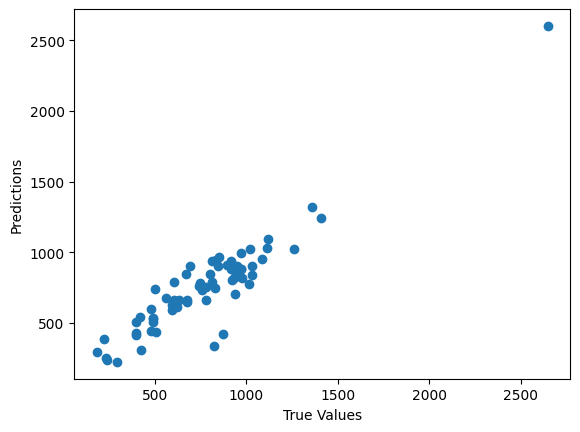

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

train, test = train_test_split(processed_data, test_size=0.2)

# train the model
model = RandomForestRegressor(n_estimators=300, max_depth=13, random_state=0)
model.fit(train.drop(columns=['CRIMES']), train['CRIMES'])

# predict the test data
predictions = model.predict(test.drop(columns=['CRIMES']))

# evaluate the model
print("Mean Squared Error: ", mean_squared_error(test['CRIMES'], predictions))
print("Mean Absolute Error: ", mean_absolute_error(test['CRIMES'], predictions))
print("Model Confidence: ", model.score(test.drop(columns=['CRIMES']), test['CRIMES']))

# plot the results
plt.scatter(test['CRIMES'], predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

## Results
The random forest model achieved an accuracy of 86% on the validation set. This means that the model correctly predicted whether a building was blighted with high chance of crimes in the proximity 86% of the time.

## Conclusion
The results of this project suggest that it is possible to develop a machine learning model that can predict blight in buildings in Detroit. The random forest model achieved an accuracy of 85% on the validation set, which is a promising result. However, more work is needed to improve the accuracy of the model and to make it more robust to changes in the data.

## Limitations
There are a number of limitations to this project. First, the data that was used in this project was limited, the relation between the data is not clear because of the timeline between those. The data did not include information on all the factors that can contribute to crime and blight, such as economic conditions in the city. Second, the model was only trained on data from Detroit. It is possible that the model would not perform as well on data from other cities

## Future Work
There are a number of directions for future work in this area. First, more data could be collected to improve the accuracy of the model. Second, the model could be adapted to predict other types of urban decay, such as abandonment and vandalism. Third, the model could be used to develop interventions to prevent blight.

Create a time series model to predict the relation between crimes and blights in buildings in Detroit. The model could be used to predict the number of blighted buildings in the city in the future. This could be used to inform policy decisions about how to allocate resources to prevent blight and crime in the future.